## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-0px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium.h5'
SAVE_MODEL_FILE = OUTPUT_DIR + 'last-model-medium.yml'
LOAD_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium.h5'
LOAD_MODEL_FILE = None

RECREATE_OUTPUT_DIR = False
RUN_TRAINING = True

OUTPUT_WEIGHT = (1,1,1,1,1,1)
TRAIN_EPOCHS = 100
INPUT_RANGE = 1

BATCH_SIZE=64

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-04-26 00:03:26,902 INFO Output dirs created


### Prepare train, validate and test data flows

In [4]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=0.7)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.7, end_ratio=0.85)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.85, end_ratio=1)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-04-26 00:03:26,935 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-84-84.h5 as input
2017-04-26 00:03:26,937 INFO preparing train data
2017-04-26 00:03:26,938 INFO loading input data for class distribution analysis...
2017-04-26 00:03:26,939 INFO loading Y from raw dataset
2017-04-26 00:03:26,940 INFO > [started] generator dump...


135062/135062

2017-04-26 00:04:04,773 INFO > [done]    generator dump (37833.035 ms)
2017-04-26 00:04:04,833 INFO raw sample class distribution
2017-04-26 00:04:04,834 INFO 0: 4930
2017-04-26 00:04:04,835 INFO 1: 3902
2017-04-26 00:04:04,836 INFO 2: 33128
2017-04-26 00:04:04,837 INFO 3: 17819
2017-04-26 00:04:04,838 INFO 4: 14882
2017-04-26 00:04:04,839 INFO 5: 60401
2017-04-26 00:04:04,840 INFO overall output samples per class: 3902
2017-04-26 00:04:04,840 INFO augmentation/undersampling ratio per class
2017-04-26 00:04:04,841 INFO SETUP FLOW 0 0.7
2017-04-26 00:04:04,842 INFO calculating source range according to start/end range of the desired output..
2017-04-26 00:04:04,843 INFO output distribution for this flow
2017-04-26 00:04:04,844 INFO 0: 2731 (0.79)
2017-04-26 00:04:04,845 INFO 1: 2731 (1.00)
2017-04-26 00:04:04,846 INFO 2: 2731 (0.12)
2017-04-26 00:04:04,847 INFO 3: 2731 (0.22)
2017-04-26 00:04:04,848 INFO 4: 2731 (0.26)
2017-04-26 00:04:04,848 INFO 5: 2731 (0.06)
2017-04-26 00:04:04,960 

135062/135062

2017-04-26 00:04:42,661 INFO > [done]    generator dump (37694.631 ms)
2017-04-26 00:04:42,721 INFO raw sample class distribution
2017-04-26 00:04:42,721 INFO 0: 4930
2017-04-26 00:04:42,723 INFO 1: 3902
2017-04-26 00:04:42,723 INFO 2: 33128
2017-04-26 00:04:42,725 INFO 3: 17819
2017-04-26 00:04:42,726 INFO 4: 14882
2017-04-26 00:04:42,727 INFO 5: 60401
2017-04-26 00:04:42,728 INFO overall output samples per class: 3902
2017-04-26 00:04:42,729 INFO augmentation/undersampling ratio per class
2017-04-26 00:04:42,730 INFO SETUP FLOW 0.7 0.85
2017-04-26 00:04:42,731 INFO calculating source range according to start/end range of the desired output..
2017-04-26 00:04:42,732 INFO output distribution for this flow
2017-04-26 00:04:42,733 INFO 0: 585 (0.79)
2017-04-26 00:04:42,734 INFO 1: 585 (1.00)
2017-04-26 00:04:42,735 INFO 2: 585 (0.12)
2017-04-26 00:04:42,736 INFO 3: 585 (0.22)
2017-04-26 00:04:42,737 INFO 4: 585 (0.26)
2017-04-26 00:04:42,738 INFO 5: 585 (0.06)
2017-04-26 00:04:42,848 INF

135062/135062

2017-04-26 00:05:20,602 INFO > [done]    generator dump (37747.200 ms)
2017-04-26 00:05:20,662 INFO raw sample class distribution
2017-04-26 00:05:20,663 INFO 0: 4930
2017-04-26 00:05:20,664 INFO 1: 3902
2017-04-26 00:05:20,665 INFO 2: 33128
2017-04-26 00:05:20,666 INFO 3: 17819
2017-04-26 00:05:20,667 INFO 4: 14882
2017-04-26 00:05:20,668 INFO 5: 60401
2017-04-26 00:05:20,668 INFO overall output samples per class: 3902
2017-04-26 00:05:20,669 INFO augmentation/undersampling ratio per class
2017-04-26 00:05:20,670 INFO SETUP FLOW 0.85 1
2017-04-26 00:05:20,671 INFO calculating source range according to start/end range of the desired output..
2017-04-26 00:05:20,672 INFO output distribution for this flow
2017-04-26 00:05:20,673 INFO 0: 585 (0.79)
2017-04-26 00:05:20,674 INFO 1: 585 (1.00)
2017-04-26 00:05:20,675 INFO 2: 585 (0.12)
2017-04-26 00:05:20,676 INFO 3: 585 (0.22)
2017-04-26 00:05:20,677 INFO 4: 585 (0.26)
2017-04-26 00:05:20,678 INFO 5: 585 (0.06)
2017-04-26 00:05:20,788 INFO 

2017-04-26 00:05:20,799 INFO BALANCE GENERATOR DATA
2017-04-26 00:05:20,801 INFO > [started] generator dump...
2017-04-26 00:05:20,801 INFO starting new flow...


16448/16388

2017-04-26 00:06:11,690 INFO > [done]    generator dump (50889.107 ms)
2017-04-26 00:06:11,691 INFO y (16388, 6)
2017-04-26 00:06:11,700 INFO [2715 2818 2867 2843 2456 2689]
2017-04-26 00:06:11,700 INFO starting new flow...
2017-04-26 00:06:11,798 INFO showing 64 images
2017-04-26 00:06:11,801 INFO > [started] generating image patches. rows=7; cols=10...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/utils.py:608: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(image_labels!=None):


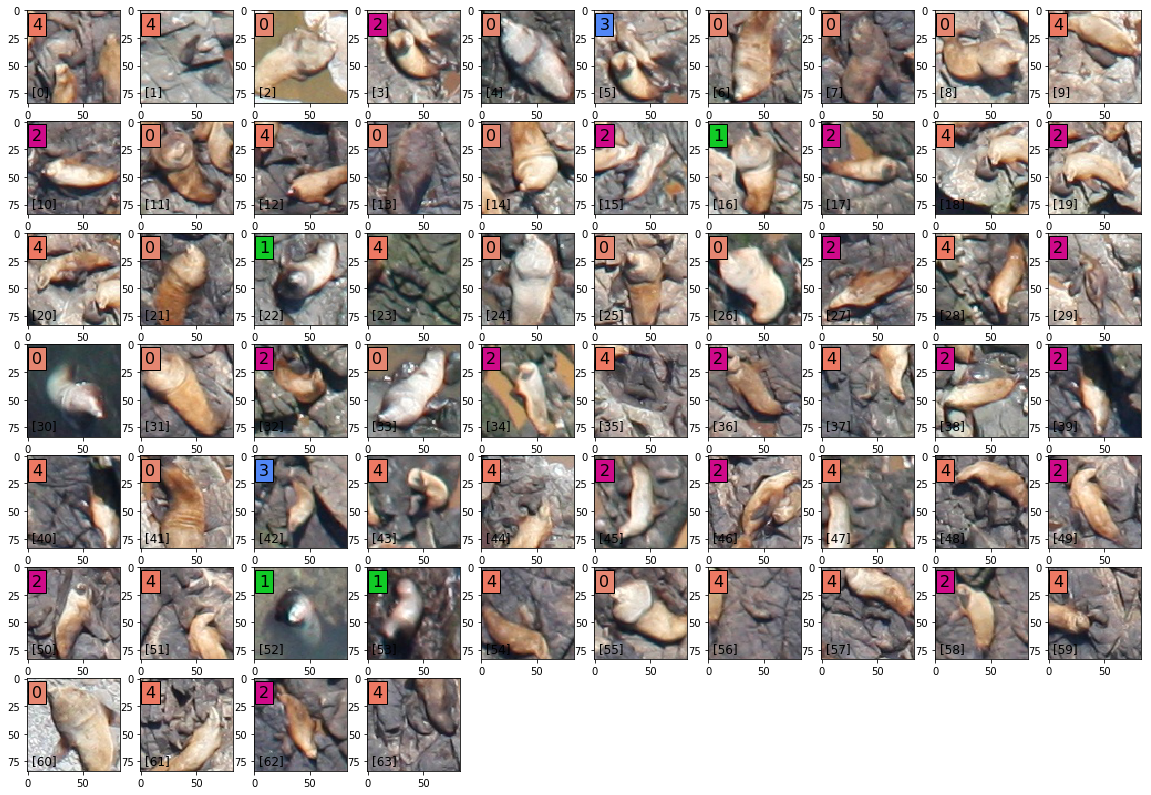

2017-04-26 00:06:18,465 INFO > [done]    generating image patches. rows=7; cols=10 (6663.844 ms)


In [5]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

for xs,ys in train_balance_generator.flow():
    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
    break

### Prepare CNN model

In [ ]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_medium_lion_keras(IMAGE_DIMS)
    logger.info('loaded model from function convnet_simple_lion_keras')
    

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])    
logger.info('Model prepared')

2017-04-26 00:06:18,498 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:69: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:71: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:72: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_initializer="glorot_uniform", padding="same", activation="relu")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same',

## Train model

In [ ]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


2017-04-26 00:06:18,818 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-04-26 00:06:19,280 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-04-26 00:06:19,285 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-04-26 00:06:19,288 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-04-26 00:06:19,294 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-04-26 00:06:19,298 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-04-26 00:06:19,303 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-04-26 00:06:19,306 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-04-26 00:06:19,312 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-04-26 00:06:19,315 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-04-26 00:06:19,320 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-04-26 00:06:19,323 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-04-26 00:06:19,328 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-04-26 00:06:19,334 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-04-26 00:06:19,343 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-04-26 00:06:19,345 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-04-26 00:06:19,351 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-04-26 00:06:19,355 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-04-26 00:06:19,360 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-04-26 00:06:19,362 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-04-26 00:06:19,368 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-04-26 00:06:19,372 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-04-26 00:06:19,380 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-04-26 00:06:19,383 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-04-26 00:06:19,389 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=100, steps_per_epoch=257, callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., validation_steps=55)`


Epoch 1/100
Epoch 1/100
256/257 [============================>.] - ETA: 0s - loss: 1.5133 - acc: 0.3340  

2017-04-26 00:08:44,159 INFO starting new flow...


Epoch 00000: val_acc improved from -inf to 0.47045, saving model to ../../output/kaggle-sea-lion/05/weights/weights-00-0.47.h5
257/257 [==============================] - 193s - loss: 1.5126 - acc: 0.3342 - val_loss: 1.2489 - val_acc: 0.4705
Epoch 2/100
Epoch 2/100
257/257 [==============================] - 188s - loss: 1.2808 - acc: 0.4753 - val_loss: 1.1507 - val_acc: 0.5190
Epoch 3/100
Epoch 3/100
257/257 [==============================] - 160s - loss: 1.2436 - acc: 0.4911 - val_loss: 1.1514 - val_acc: 0.5330
Epoch 4/100
Epoch 4/100
257/257 [==============================] - 160s - loss: 1.1880 - acc: 0.5106 - val_loss: 1.0532 - val_acc: 0.5716
Epoch 5/100
Epoch 5/100
257/257 [==============================] - 189s - loss: 1.1526 - acc: 0.5359 - val_loss: 1.0130 - val_acc: 0.5949
Epoch 6/100
Epoch 6/100
257/257 [==============================] - 148s - loss: 1.1208 - acc: 0.5435 - val_loss: 1.0246 - val_acc: 0.5682
Epoch 7/100
Epoch 7/100
257/257 [==============================] - 16

### Epoch accuracy/loss

In [ ]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

In [ ]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=lions.CLASS_LABELS)

In [ ]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 50, model)